In [24]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random
import bisect

import sys
sys.path.insert(0,'..')

In [25]:
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:7


# 1. Load the data and get measurements

In [26]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 23

In [27]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [28]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [29]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (3, 2, 2081)
GT S-parameters shape:  (3, 2, 2081)
Y S-parameters shape:  (3, 2, 155)


In [30]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (2081,)
Y frequencies shape:  (155,)


In [31]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  40000000.0
Mean frequency spacing:  19211538.46153846
STD frequency spacing:  6057692.307692306
Mode frequency spacing:  18000000.0
Number of samples with non-equal spacing:  81


In [32]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [33]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  2081
N_SPARAMS:  3


In [34]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 6, 2081])


In [35]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 3, 2081])


## Plot some stuff

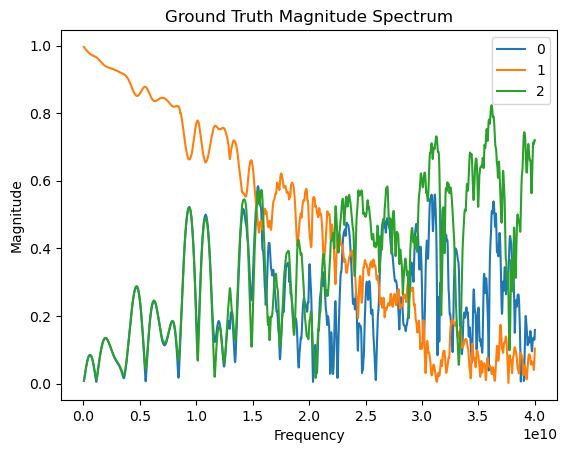

In [36]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

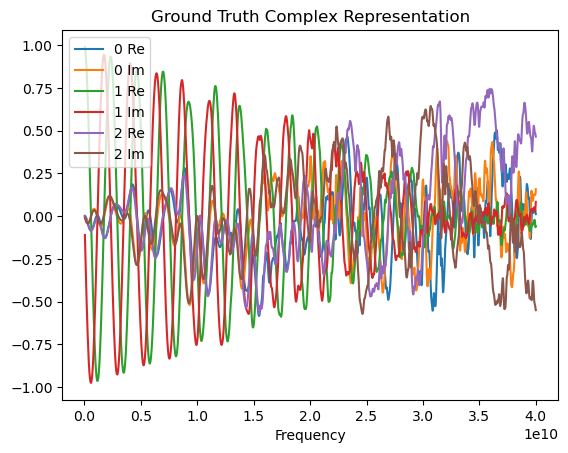

In [37]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [38]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 155

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)
old_kept = kept_inds.copy()

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

# remove every other point, starting at the back, don't remove first point
remove = False
for i in range(len(kept_inds) - 1, 0, -1):
    if remove:
        kept_inds = np.delete(kept_inds, [i])
        remove = False
    else:
        remove = True


print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)
print(old_kept)

Number of Ground Truth Frequency Points:  2081
Number of Measurements:  155
Undersampling Ratio:  0.07448342143200384
[   0   27   54   81  108  135  162  189  216  243  270  297  324  351
  378  405  432  459  486  513  540  567  594  621  648  675  702  729
  756  783  810  837  864  891  918  945  972  999 1026 1053 1080 1107
 1134 1161 1188 1215 1242 1269 1296 1323 1350 1377 1404 1431 1458 1485
 1512 1539 1566 1593 1620 1647 1674 1701 1728 1755 1782 1809 1836 1863
 1890 1917 1944 1971 1998 2025 2052 2080]
[   0   13   27   40   54   67   81   94  108  121  135  148  162  175
  189  202  216  229  243  256  270  283  297  310  324  337  351  364
  378  391  405  418  432  445  459  472  486  499  513  526  540  553
  567  580  594  607  621  634  648  661  675  688  702  715  729  742
  756  769  783  796  810  823  837  850  864  877  891  904  918  931
  945  958  972  985  999 1012 1026 1040 1053 1067 1080 1094 1107 1121
 1134 1148 1161 1175 1188 1202 1215 1229 1242 1256 1269 128

In [39]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 6, 78])
y_freqs shape:  (78,)


# 2. Network Setup

## Define network parameters

In [40]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [41]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  6
NUM_LAYERS:  8
BASE NGF:  16
NGF:  [16, 16, 16, 16, 16, 16, 16, 16]
BS:  1
NC:  6
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [42]:
from models import RES_UNET

ENSEMBLE_SIZE = 5

ensemble = [RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               ) for i in range(ENSEMBLE_SIZE)]
for net in ensemble:
    net = net.to(device)

# Choose one network to visualize the results
net = ensemble[ENSEMBLE_SIZE // 2]

In [43]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 6, 2081])


In [44]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  30098


# 3. Run

In [45]:
def find_max_variance(n, outputs, kept_inds, pickRandom=False):
    # Outputs of shape [ENSEMBLE_SIZE, 20, 1000]
    print("each output: ", outputs[0].shape)

    # Call np.var with dim = 0 to get shape [20, 1000]
    stacked_output = torch.cat(outputs, dim=0)
    print("after cat: ", stacked_output.shape)

    var_output = torch.var(stacked_output, dim=0)
    print("after var: ", var_output.shape)

    # Sum to go to [1000]
    var_output = torch.sum(var_output, dim=0)

    print("after sum: ", var_output.shape)

    if pickRandom:
        while True:
            rand_idx = random.randint(0, len(var_output) - 1)
            if rand_idx not in kept_inds:
                print("picked: ", rand_idx)
                return rand_idx

    _, idxs = torch.topk(var_output, len(var_output))

    indices = []
    insertion_index_set = set()
    for idx in idxs:
        if idx.item() not in kept_inds:

            insertion_index = bisect.bisect(kept_inds, idx.item())
            if insertion_index in insertion_index_set:
                continue
            insertion_index_set.add(insertion_index)

            indices.append(idx.item())
            if len(indices) == n:
                print("selected: ", indices)
                return indices
    return -1

## Define training parameters, losses, and track stats

In [46]:
#grab the correct file we want for VF
NUM_ACTIVE = M - len(kept_inds)
NUM_ACTIVE_SCHEDULE = [NUM_ACTIVE // 5 for _ in range(5)]
for k in range(NUM_ACTIVE % 5):
    NUM_ACTIVE_SCHEDULE[k] += 1

print("schedule", NUM_ACTIVE_SCHEDULE)

LR = 2e-4
FIRST_ITER = 20000
NUM_ITER = 5000
TOTAL_ITERS = FIRST_ITER + NUM_ITER * len(NUM_ACTIVE_SCHEDULE)

REG_HYPERPARAM = 1.0
NOISY_INPUT = True

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optims = [torch.optim.Adam(ensemble[i].parameters(), lr=LR) for i in range(ENSEMBLE_SIZE)]
        
START_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS)
CUR_NOISE_LEVELS = [START_NOISE_LEVEL for i in range(ENSEMBLE_SIZE)]

ensemble_outputs = [None for i in range(ENSEMBLE_SIZE)]
ensemble_all_outputs = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_train_losses = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_train_errors = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_train_regs = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_test_mses = [[] for i in range(ENSEMBLE_SIZE)]
ensemble_test_maes = [[] for i in range(ENSEMBLE_SIZE)]

is_initial_fit = True
tic = time.time()
net.train()
print("NUM ACTIVE: ", NUM_ACTIVE)

CURR_ITER = FIRST_ITER

for num_actively_sampled in range(len(NUM_ACTIVE_SCHEDULE) + 1):

    if not is_initial_fit:

        # Find the maximum standard deviation point, and use it to update kept_inds
        max_disagree_indices = find_max_variance(NUM_ACTIVE_SCHEDULE[num_actively_sampled - 1], ensemble_outputs, kept_inds, pickRandom=False)
        kept_inds = np.sort(np.concatenate([kept_inds, max_disagree_indices]))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]

    for j, net in enumerate(ensemble):

        net.train()

        # Update the criterion to reflect the new point we have sampled
        criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
        criterion = criterion.to(device)
        optim = optims[j]
        train_losses = []
        train_errors = []
        train_regs = []
        test_mses = []
        test_maes = []

        for i in range(int(CURR_ITER)):
            optim.zero_grad()
            
            if NOISY_INPUT:
                out = net.forward_with_z(CUR_NOISE_LEVELS[j])
                CUR_NOISE_LEVELS[j] *= NOISE_DECAY_FACTOR
            else:
                out = net.forward_with_z()
            
            train_error = criterion(out, y) 
            if REG_HYPERPARAM > 0:
                train_reg = REG_HYPERPARAM * regularizer(out)
                train_loss = train_error + train_reg
            else:
                train_loss = train_error
            
            train_loss.backward()
            optim.step()

            with torch.no_grad():
                
                # Log the standard metrics across different numbers of samples given
                train_losses.append(train_loss.item())
                train_errors.append(train_error.item())
                if REG_HYPERPARAM > 0:
                    train_regs.append(train_reg.item())
                
                test_mse = nn.MSELoss()(out, x)
                test_mses.append(test_mse.item())
                
                test_mae = nn.L1Loss()(out, x)
                test_maes.append(test_mae.item())

                if (i+1)%1000 == 0 or i == 0:
                    toc = time.time()
                    print("ensemble idx: ", j)
                    print("ITER ", str(i))
                    print("TIME: ", str(toc - tic))
                    if NOISY_INPUT:
                        print("NOISE LEVEL: ", CUR_NOISE_LEVELS[j])
                    print()

        ensemble_outputs[j] = out
        ensemble_all_outputs[j].append(out)
        ensemble_train_losses[j].append(train_losses)
        ensemble_train_errors[j].append(train_errors)
        ensemble_train_regs[j].append(train_regs)
        ensemble_test_mses[j].append(test_mses)
        ensemble_test_maes[j].append(test_maes)

    if is_initial_fit :
        CURR_ITER = NUM_ITER
        is_initial_fit = False

print("NUM_SAMPLES ", str(num_actively_sampled))
print("TIME: ", str(toc - tic))


schedule [16, 16, 15, 15, 15]
NUM ACTIVE:  77
ensemble idx:  0
ITER  0
TIME:  0.0389714241027832
NOISE LEVEL:  0.9998465061085267

ensemble idx:  0
ITER  999
TIME:  27.156594038009644
NOISE LEVEL:  0.8576958985908681

ensemble idx:  0
ITER  1999
TIME:  56.5035126209259
NOISE LEVEL:  0.7356422544595946

ensemble idx:  0
ITER  2999
TIME:  84.91925740242004
NOISE LEVEL:  0.6309573444801337

ensemble idx:  0
ITER  3999
TIME:  111.50436043739319
NOISE LEVEL:  0.5411695265463959

ensemble idx:  0
ITER  4999
TIME:  138.24269580841064
NOISE LEVEL:  0.46415888336120453

ensemble idx:  0
ITER  5999
TIME:  164.5787718296051
NOISE LEVEL:  0.3981071705534224

ensemble idx:  0
ITER  6999
TIME:  190.95906114578247
NOISE LEVEL:  0.3414548873832853

ensemble idx:  0
ITER  7999
TIME:  217.37102150917053
NOISE LEVEL:  0.29286445646245096

ensemble idx:  0
ITER  8999
TIME:  243.85736227035522
NOISE LEVEL:  0.2511886431508878

ensemble idx:  0
ITER  9999
TIME:  270.32862663269043
NOISE LEVEL:  0.2154434690

In [47]:
def bo_stack(list_list_tensor, squeeze=True):
    new_list = []
    for l in list_list_tensor:
        new_list.append(torch.stack(l))
    
    stacked = torch.stack(new_list)
    if squeeze:
        stacked = torch.squeeze(stacked)
    assert len(stacked.shape) == 4 # fuck
    return stacked

In [48]:
ensemble_outputs_stacked = bo_stack(ensemble_all_outputs)
# print(len(ensemble_train_losses[0][0]))
# print(len(ensemble_train_losses[-1]))
# train_losses = np.mean(ensemble_train_losses, axis=0).flatten()
# train_losses = np.concatenate(ensemble_train_losses)

train_losses_list = []
train_errors_list = []
test_maes_list = []
test_mses_list = []
for i in range(ENSEMBLE_SIZE):
    # print(len(ensemble_train_losses[i]))
    concat_list_losses = []
    concat_list_errors = []
    concat_list_maes = []
    concat_list_mses = []
    for j in range(len(ensemble_train_losses[i])):
        concat_list_losses.extend(ensemble_train_losses[i][j])
        concat_list_errors.extend(ensemble_train_errors[i][j])
        concat_list_maes.extend(ensemble_test_maes[i][j])
        concat_list_mses.extend(ensemble_test_mses[i][j])
    train_losses_list.append(concat_list_losses)
    train_errors_list.append(concat_list_errors)
    test_maes_list.append(concat_list_maes)
    test_mses_list.append(concat_list_mses)
train_losses = np.mean(train_losses_list, axis=0)
train_errors = np.mean(train_errors_list, axis=0)
test_maes = np.mean(test_maes_list, axis=0)
test_mses = np.mean(test_mses_list, axis=0)

# train_errors = np.mean(ensemble_train_errors, axis=0).flatten()
# test_maes = np.mean(ensemble_test_maes, axis=0).flatten()
# test_mses = np.mean(ensemble_test_mses, axis=0).flatten()

# Then, get the mean and variance of the actual output shape
# (1, S_PARAMS, FREQS)
out = torch.mean(torch.stack(ensemble_outputs), dim=0)
var_out = torch.var(torch.stack(ensemble_outputs), dim=0)

## Plot metrics and outputs

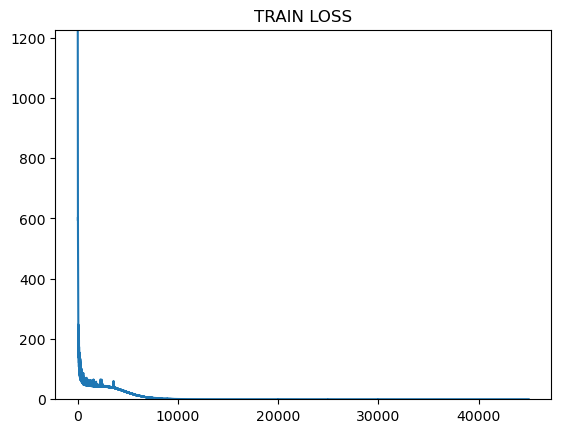

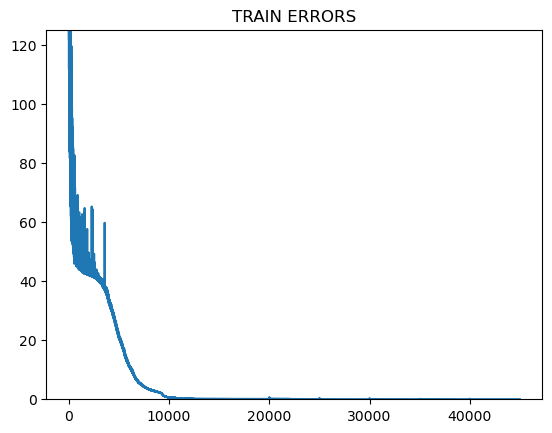

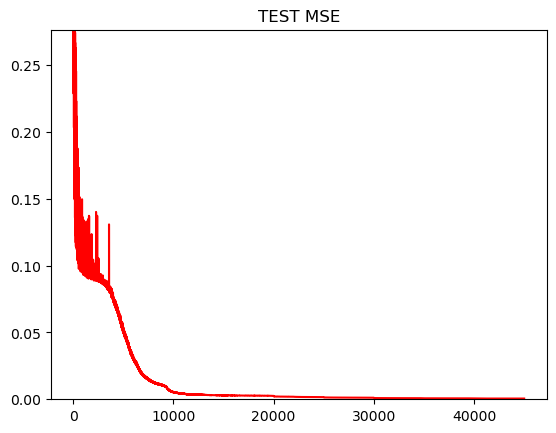

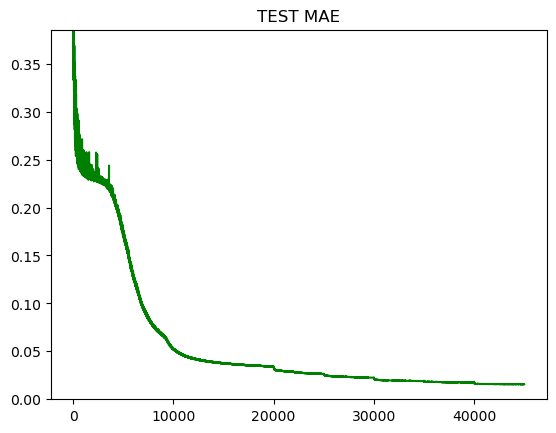

In [49]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [50]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.0005465407855808734
Best Test MSE:  0.0005449347896501422
Best Test MSE Iteration:  44954


In [51]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case23/case23.s2p
[4.0000e+07 4.3600e+08 4.8550e+08 5.3500e+08 6.8350e+08 1.3765e+09
 1.7230e+09 1.9210e+09 1.9705e+09 2.3170e+09 2.7130e+09 2.7625e+09
 3.1090e+09 4.0180e+09 4.2160e+09 4.5040e+09 4.7380e+09 4.9900e+09
 5.2240e+09 5.4760e+09 5.9620e+09 6.4480e+09 6.7000e+09 6.9340e+09
 7.2040e+09 7.4200e+09 7.6900e+09 7.9060e+09 8.3920e+09 8.6260e+09
 8.8780e+09 9.1480e+09 9.1840e+09 9.2020e+09 9.2200e+09 9.3640e+09
 9.5980e+09 9.8500e+09 1.0336e+10 1.0822e+10 1.1308e+10 1.1794e+10
 1.2280e+10 1.2766e+10 1.3072e+10 1.3252e+10 1.3738e+10 1.4224e+10
 1.4710e+10 1.5196e+10 1.5682e+10 1.6168e+10 1.6654e+10 1.6906e+10
 1.7140e+10 1.7626e+10 1.8112e+10 1.8598e+10 1.9084e+10 1.9570e+10
 1.9840e+10 2.0056e+10 2.0290e+10 2.0542e+10 2.1028e+10 2.1262e+10
 2.1514e+10 2.2000e+10 2.2270e+10 2.2486e+10 2.2648e+10 2.2792e+10
 2.2882e+10 2.2954e+10 2.2972e+10 2.2990e+10 2.3008e+10 2.3134e+10
 2.3458e+10 2.3728e+10 2.3944e+10 2.3962e+10 2.4430e+10 2.4538e+1

/u/bodeng/CurveFitting-DIP/ensemble_n_at_a_time/../VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.10481542348861694 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 3 poles better than 2 (err 1.4342764667858048 vs 1.6460486110569543)
Performing fit with 3 poles.
  Fitting took 0.15401486307382584 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.


/u/bodeng/CurveFitting-DIP/ensemble_n_at_a_time/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. 
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fit with 4 poles better than 3 (err 1.3476586322559259 vs 1.4342764667858048)
Performing fit with 4 poles.
  Fitting took 0.13691830076277256 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 1.100102991875417 vs 1.3476586322559259)
Performing fit with 5 poles.
  Fitting took 0.20462635159492493 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 was not subtantially better than 5 (err 1.8304223200678573 vs 1.100102991875417)
Performing fit with 6 poles.
  Fitting took 0.22745932079851627 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 poles better than 5 (err 1.0002184970952754 vs 1.100102991875417)
Performing fit with 7 poles.
  Fitting took 0.2168197315186262 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 8 was not subtantially better than 7 (err 1.0167563870347986 v

In [52]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
# print("Mean DIP MSE: ", nn.MSELoss()([-1][np.newaxis], x).item())

torch.Size([2081, 2, 2, 2])
torch.Size([2081, 2, 2, 2])
torch.Size([155, 2, 2, 2])
(2081, 2, 2, 2)
(2081, 2, 2, 2)
(3, 2, 2081)
(3, 2, 2081)
float32
float32
DIP PSNR:       38.90733988757499
VF PSNR:        26.3258648731304
Final DIP MSE:  0.0005465407855808734
VF MSE:         0.009321236051619053


(2081,)
torch.Size([1, 6, 2081])
torch.Size([1, 6, 155])
torch.Size([1, 6, 2081])
torch.Size([1, 6, 2081])


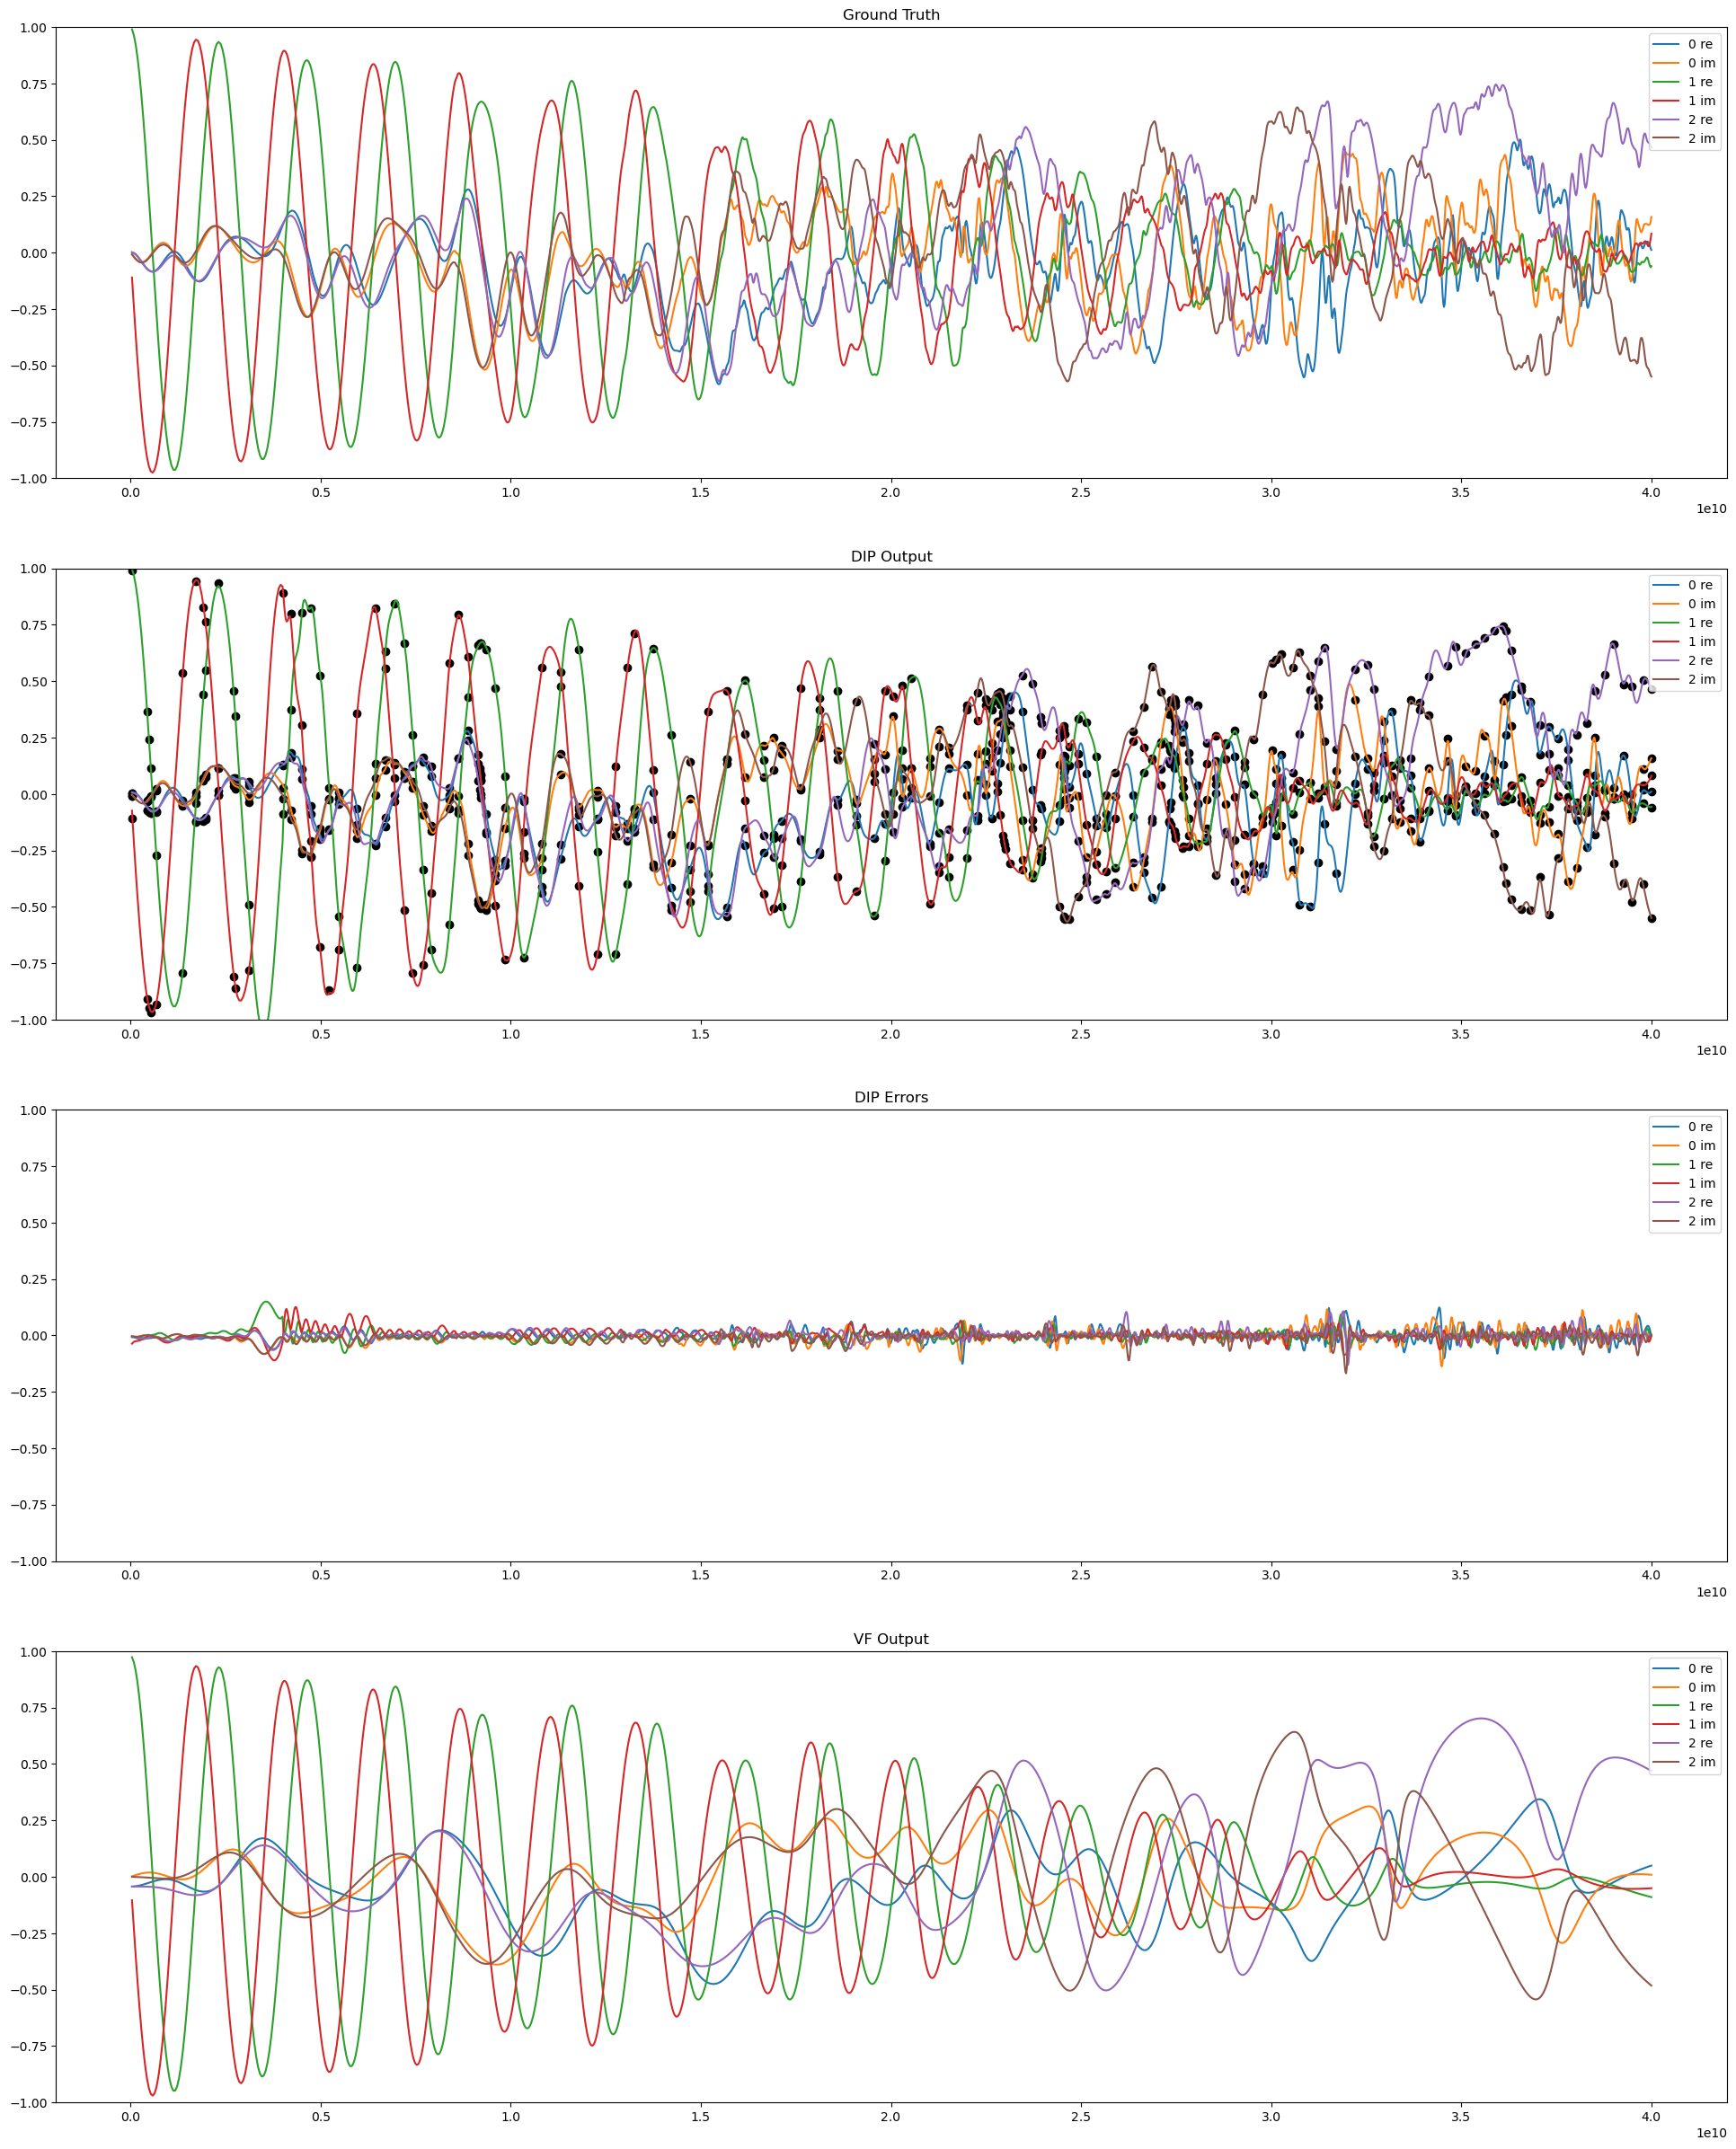

In [53]:
dip_errors = x.detach().cpu() - out.detach().cpu()
print(gt_freqs.shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")

    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')

axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

# # DIP Variances
# for i in range(N_SPARAMS):
#     axes[4].plot(gt_freqs, var_out[0,2*i].detach().cpu(), label=str(i)+" re")
#     axes[4].plot(gt_freqs, var_out[0,2*i+1].detach().cpu(), label=str(i)+" im")
# axes[4].set_title("DIP Variances")
# if N_SPARAMS <= 10:
#     axes[4].legend(loc='upper right')

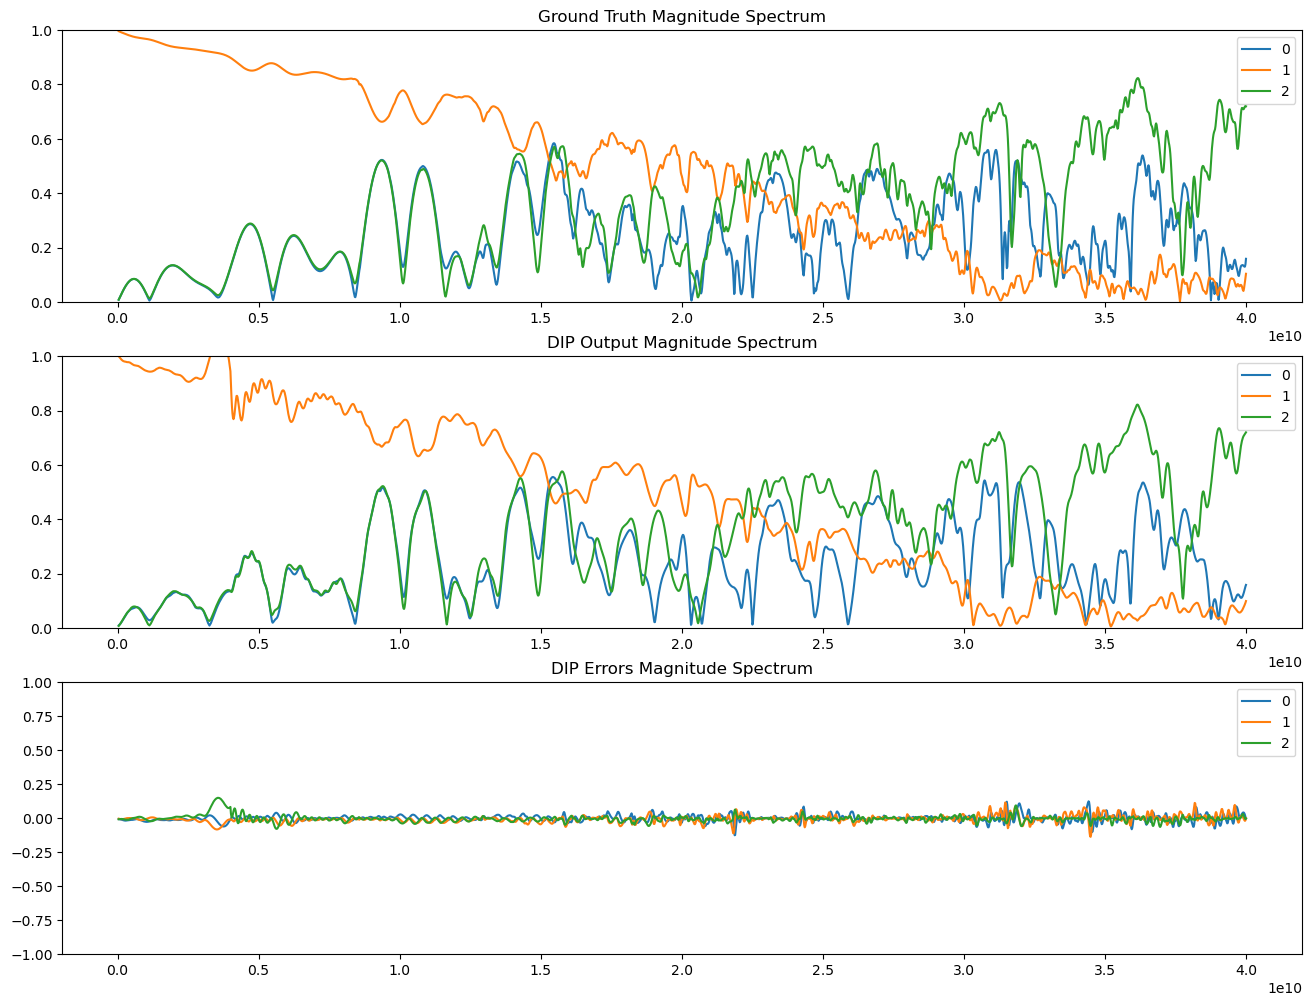

In [54]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [55]:
print(kept_inds)

[   0    8    9   10   13   27   34   38   39   46   54   55   62   81
   92  108  121  135  148  162  189  216  230  243  258  270  285  297
  324  337  351  366  368  369  370  378  391  405  432  459  486  513
  540  567  584  594  621  648  675  702  729  756  783  797  810  837
  864  891  918  945  960  972  985  999 1026 1039 1053 1080 1095 1107
 1116 1124 1129 1133 1134 1135 1136 1143 1161 1176 1188 1189 1215 1221
 1222 1223 1230 1242 1255 1269 1283 1296 1323 1338 1350 1363 1375 1377
 1378 1383 1384 1385 1395 1396 1404 1417 1431 1444 1458 1471 1485 1499
 1512 1526 1532 1539 1556 1566 1582 1593 1602 1620 1647 1665 1674 1689
 1701 1713 1728 1742 1755 1782 1794 1809 1823 1836 1850 1863 1867 1875
 1890 1903 1917 1930 1944 1958 1971 1986 1998 2012 2025 2039 2052 2068
 2080]
